#### Татур А.А.
#### v. 0.4
#### 16.11.2022

#### Задание

1. Проанализировать данные по выживаемости. Обучить модель предсказания выживет ли человек или нет.
2. Определить наиболее значимые переменные которые влияют на выживаемость. 
3. Визуализировать дерево решений. 
4. Написать вывод и ответить на вопросы:
- Как влияет размер семьи  на вероятность виживаемости (одинокие выживают чаще или нет?, люди у которых большая семья (больше 4) выживают чаще или нет).
- Как влияет пол/возраст/номер палубы. 



In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [48]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

train_data = train_data.set_index('PassengerId')
test_data = test_data.set_index('PassengerId')

df = pd.concat([train_data, test_data], axis=0, sort=False)

# Заполняем пропуски

###### Обрабатываем колонку Sex

In [49]:
df.loc[df.Sex=='male','Sex_coded']=0
df.loc[df.Sex=='female','Sex_coded']=1

###### Обрабатываем колонку Embarked

In [50]:
df.Embarked.fillna('S', inplace=True)

##### Обрабатываем колонку Age.

In [51]:
#### Заполняем пропуски средним значением в зависимости от пола и класса.
df.Age = df.Age.fillna(df.groupby(['Pclass','Sex'])['Age'].transform('median'))

<AxesSubplot:>

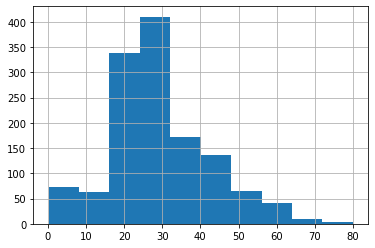

In [52]:
df.Age.hist()

<AxesSubplot:xlabel='Age', ylabel='count'>

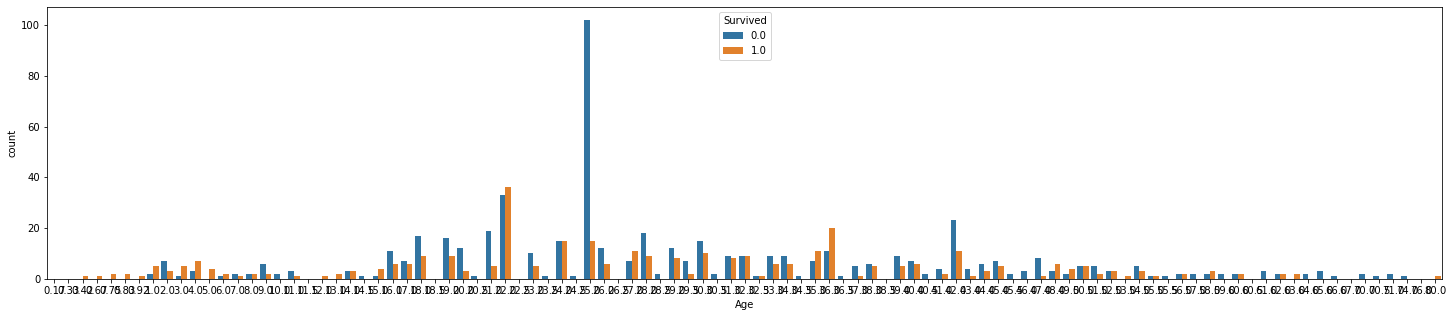

In [53]:
plt.figure(figsize=(25,5))
sns.countplot(x='Age', hue='Survived', data=df)

<AxesSubplot:xlabel='Age', ylabel='count'>

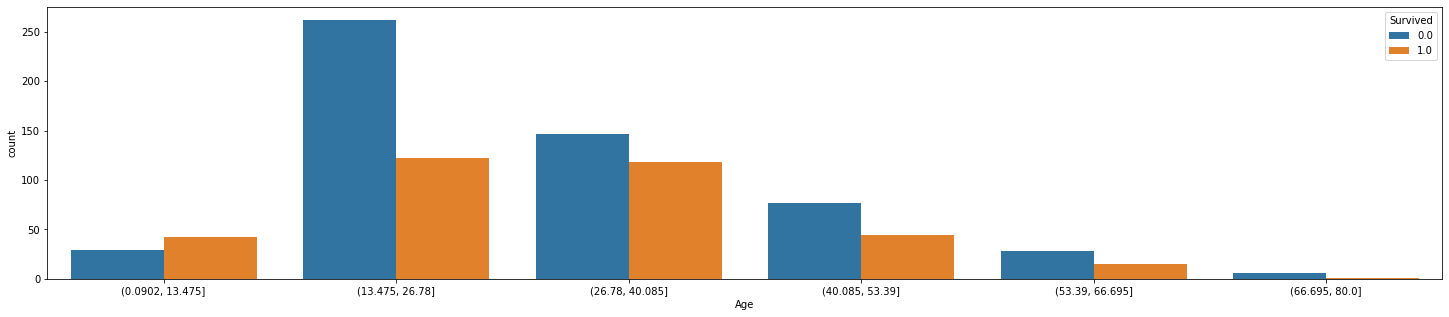

In [54]:
age_binned = pd.cut(df.Age,6)

plt.figure(figsize=(25,5))
sns.countplot(x=age_binned, hue='Survived', data=df)

In [55]:
df['Age_binned']=LabelEncoder().fit_transform(age_binned)

##### Обрабатываем колонку Fare.

In [56]:
#### Предполагаем, что нулевые значения в колонке Fare - ошибка. Заменяем их на np.nan.
df.loc[df.Fare==0, 'Fare'] = np.nan
#### Заменяем все пропущенные значеняи 
df.Fare.fillna(df.groupby(['Pclass','Sex'])['Age'].transform('median'),inplace=True)

In [57]:
#### Вытаскиываем у имеющихся первую букву каюты, остальные меняем на unkn - неизвестные. Создаем переменную Deck (палуба)
df.Cabin.fillna('no', inplace=True)
df.loc[df.Cabin.str.contains('A'),'Deck']='A'
df.loc[df.Cabin.str.contains('B'),'Deck']='B'
df.loc[df.Cabin.str.contains('C'),'Deck']='C'
df.loc[df.Cabin.str.contains('D'),'Deck']='D'
df.loc[df.Cabin.str.contains('E'),'Deck']='E'
df.loc[df.Cabin.str.contains('F'),'Deck']='F'
df.loc[df.Cabin.str.contains('G'),'Deck']='G'
df.loc[df.Cabin.str.contains('T'),'Deck']='T'
df.loc[df.Cabin=='no', 'Deck']='unknown'

<AxesSubplot:xlabel='Deck', ylabel='count'>

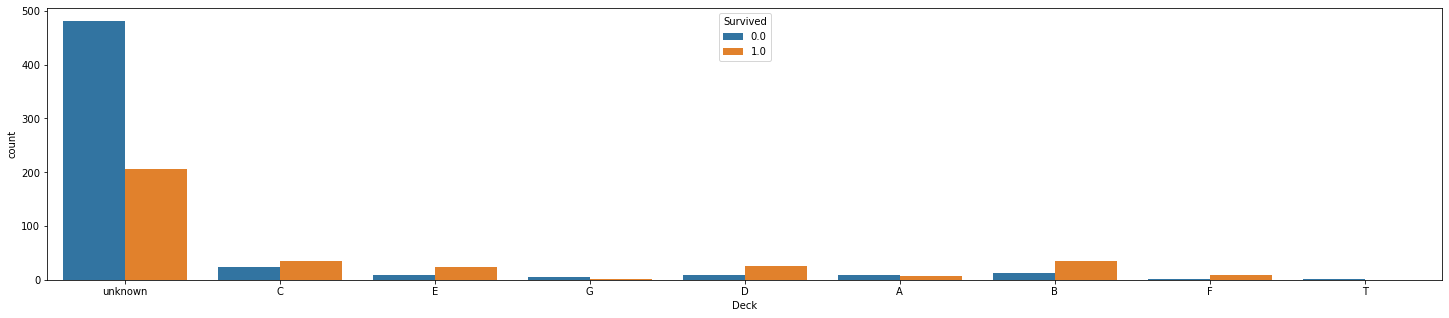

In [58]:
plt.figure(figsize=(25,5))
sns.countplot(x=df.Deck, hue='Survived', data=df)

##### Обрабатываем колонку Ticket.

In [15]:
#####  Происто извлекаем циферную часть, LINE Заменяем на 0
df.Ticket = df.Ticket.str.split().apply(lambda x: 0 if x[:][-1]=='LINE' else x[:][-1])
df.Ticket = (MinMaxScaler(feature_range=(0,1)).fit_transform(df.Ticket[:,np.newaxis])).ravel();

C:\Users\Антон\AppData\Local\Temp\ipykernel_13180\3142929921.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df.Ticket = (MinMaxScaler(feature_range=(0,1)).fit_transform(df.Ticket[:,np.newaxis])).ravel();


# Создаем новые признаки

##### Новый признак - Фамилия и Титул

In [16]:
##### 1. Извлекаем титулы и создаем колонку Title. 
###### 2. Извлекаем фамилии и создаем колонку Surname
df['Title'] = df.Name.str.extract("([a-zA-Z]+)\.", expand = False)
df['Surname'] = df.Name.str.extract('^(.+?),', expand = False)

<AxesSubplot:xlabel='Title', ylabel='count'>

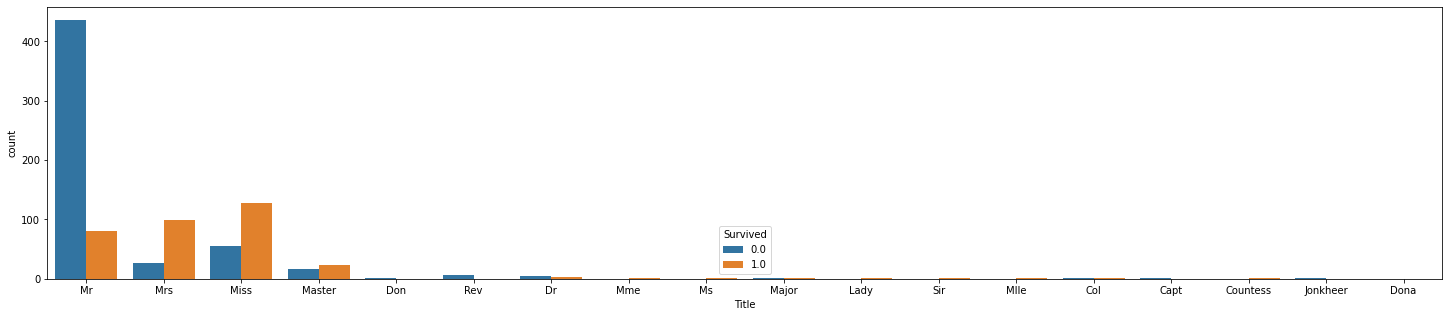

In [17]:
plt.figure(figsize=(25,5))
sns.countplot(x='Title', hue='Survived', data=df)

In [18]:
rare_titles = ['Rev','Dr','Col','Major','Capt','Jonkheer']
df.Title = df.Title.replace(['Mlle','Ms','Lady','Mme','Miss','Mrs','Countess','Dona'], 'Miss/Mrs')
df.Title = df.Title.replace(['Don','Sir'],'Mr')
df.Title = df.Title.replace(rare_titles, 'Mr')

<AxesSubplot:xlabel='Title', ylabel='count'>

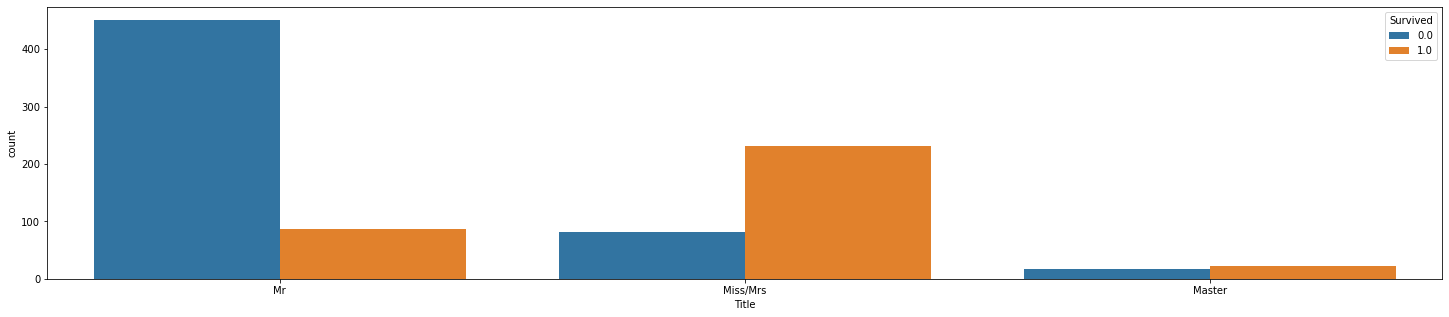

In [19]:
plt.figure(figsize=(25,5))
sns.countplot(x='Title', hue='Survived', data=df)

##### Создем новый признак - Количество членов в семье

In [20]:
df['FamilySize'] = df.SibSp+df.Parch+1

<AxesSubplot:xlabel='FamilySize', ylabel='count'>

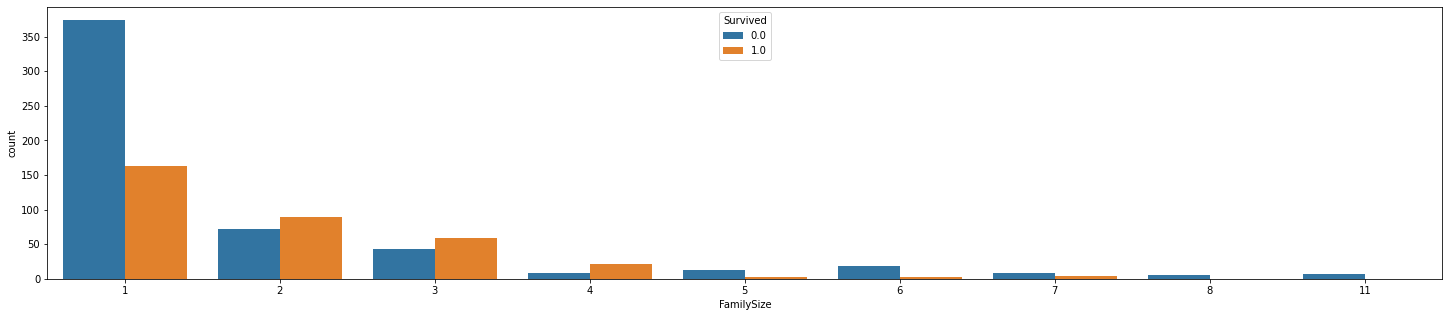

In [21]:
plt.figure(figsize=(25,5))
sns.countplot(x='FamilySize', hue='Survived', data=df)

In [22]:
df.loc[ df['FamilySize'] == 1, 'FamilySize'] = 0                           #Alone
df.loc[(df['FamilySize'] > 1) & (df['FamilySize'] <= 4), 'FamilySize'] = 1 #Small 
df.loc[(df['FamilySize'] > 4), 'FamilySize'] = 2 #Big

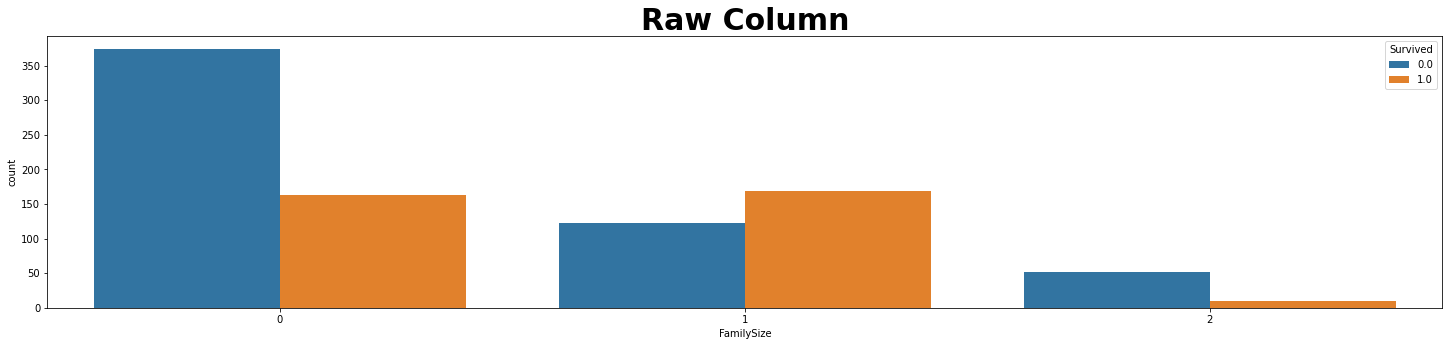

In [23]:
plt.figure(figsize=(25,5))
sns.countplot(x='FamilySize', hue='Survived', data=df).set_title("Raw Column",fontdict= { 'fontsize': 30, 'fontweight':'bold'});

##### Новый признак - женщина или ребенок (Women or Kid = WoK)

In [24]:
df['WoK'] = ((df.Age < 10) | (df.Sex == 'female'))

In [25]:
df.WoK=df['WoK'].astype(int)

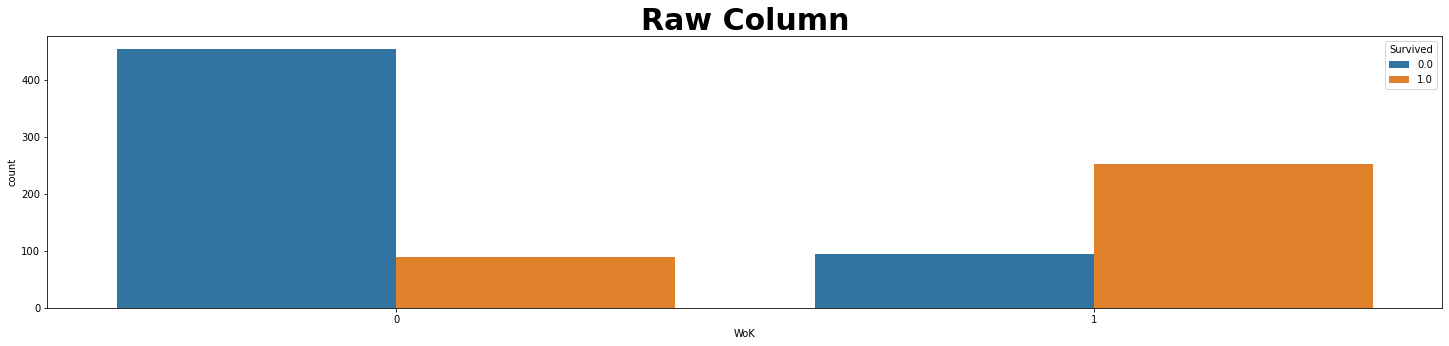

In [26]:
plt.figure(figsize=(25,5))
sns.countplot(x='WoK', hue='Survived', data=df).set_title("Raw Column",fontdict= { 'fontsize': 30, 'fontweight':'bold'});

##### Новый признак. Разбиваем доход по градациям

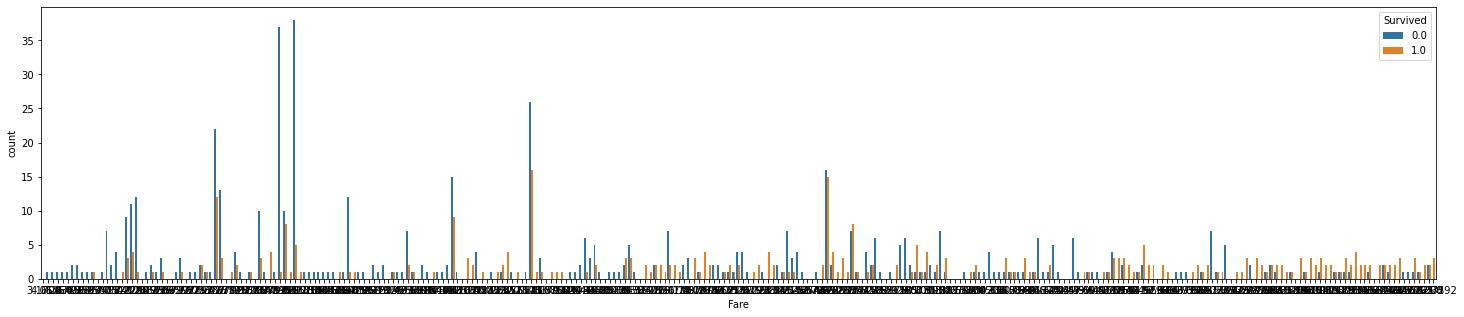

In [27]:
plt.figure(figsize=(25,5))
sns.countplot(x='Fare', hue='Survived',data=df);

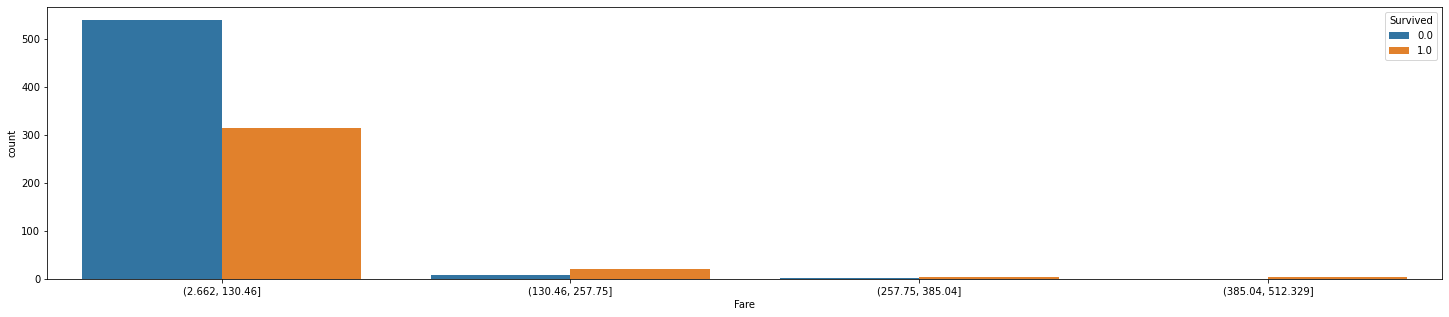

In [28]:
# С учетом того, что на графике видно, что примерно в первой четверти всех значений Fare - Большая часть погибла, а в последней четверти - выжила.
# Оптимально разбить весь график по диапазонам

binned_fare = pd.cut(df.Fare, 4)
plt.figure(figsize=(25,5))
sns.countplot(x=binned_fare, hue='Survived', data=df);

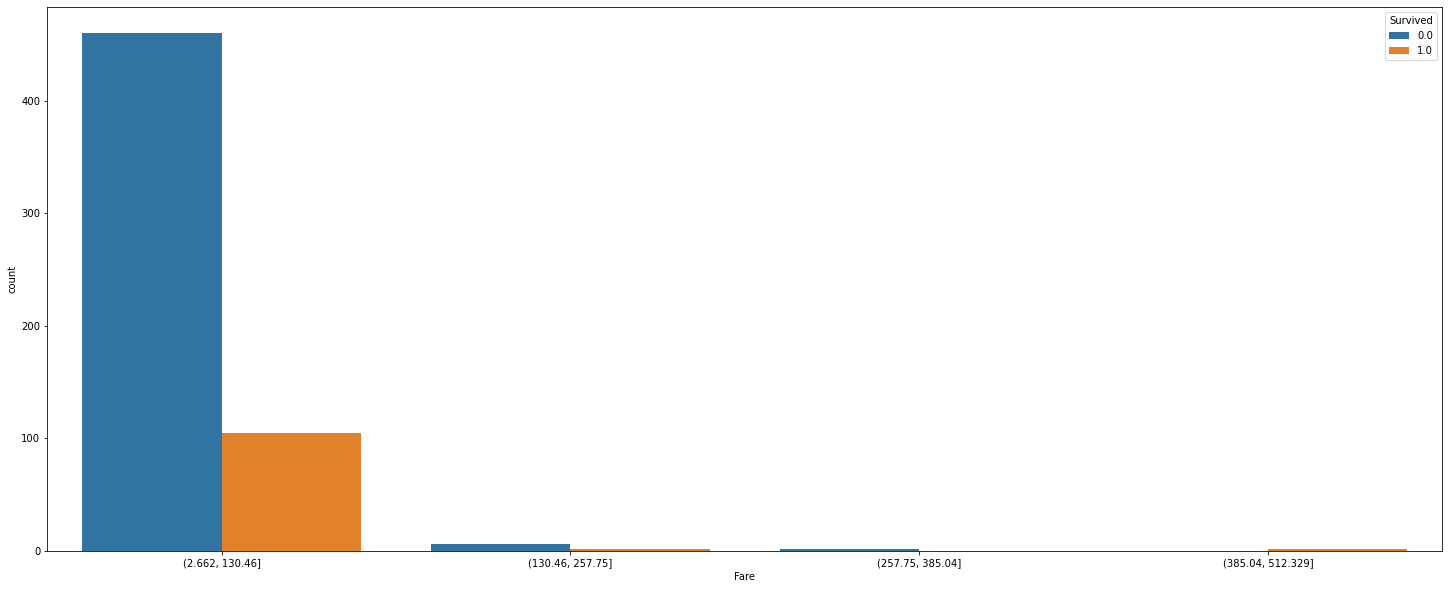

In [29]:
#### Оценка смертности среди мужчин в зависимости от дохода

binned_male = pd.cut(df.loc[df.Sex=='male']['Fare'],4)

plt.figure (figsize=(25,10))
sns.countplot(x=binned_male, hue='Survived', data=df);


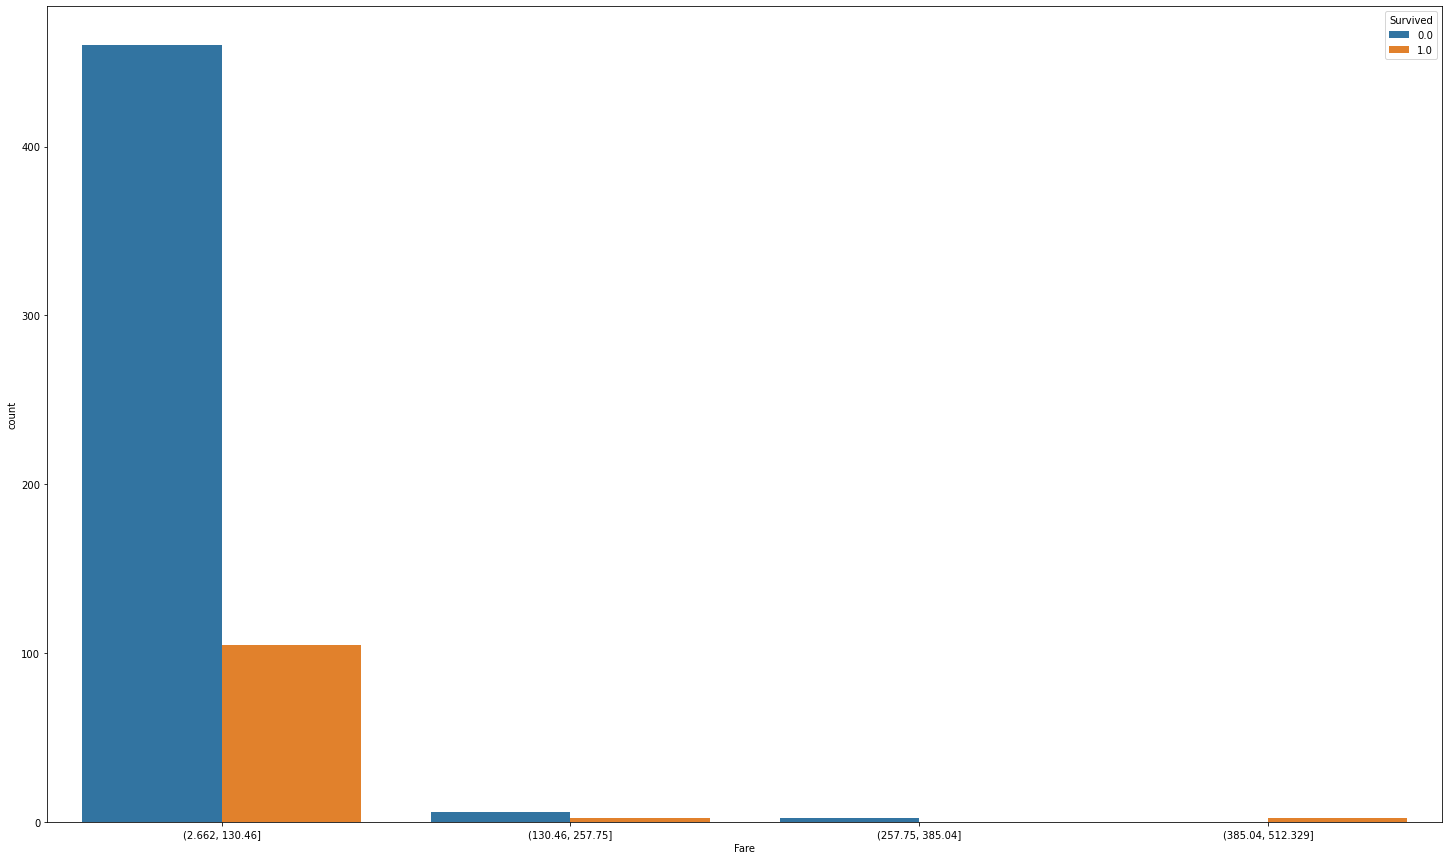

In [30]:
#### Оценка смертности среди женщин в зависимости от дохода
binned_female = pd.cut(df.loc[df.Sex=='male']['Fare'],4)

plt.figure (figsize=(25,15))
sns.countplot(x=binned_female, hue='Survived', data=df);


In [31]:
df['Fare']=LabelEncoder().fit_transform(binned_fare)

# Кодируем качественные переменные. Удаляем их из набора

##### Обрабатываем фрейм при помощи pd.get_dummies

In [32]:
df = pd.concat ([df,
                pd.get_dummies (df.Embarked, prefix = 'Embarked'),
                pd.get_dummies (df.Title, prefix = 'Title'),
                pd.get_dummies (df.Surname, prefix = 'Surname'),
                pd.get_dummies (df.Deck, prefix = 'Deck')], axis=1)

In [33]:
df.drop (['Embarked', 'Title', 'Name', 'Surname','Cabin','Sex','Cabin', 'Deck'], axis = 1, inplace=True)

##### Моделирование

###### Разбиваем анализируемый набор снова на train и test

In [34]:
train, test = df.loc[train_data.index], df.loc[test_data.index]

In [35]:
X=train.drop(['Survived'], axis=1)
y=train.Survived.astype(int)

test.drop(['Survived'], axis=1, inplace = True)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, train_size=0.2)

In [38]:
from sklearn.model_selection import cross_val_score
rfc = RandomForestClassifier(n_estimators=1000, max_depth=10, n_jobs=-1)
scores = cross_val_score(rfc, X, y, cv=5)
scores

array([0.82681564, 0.8258427 , 0.8258427 , 0.79775281, 0.85955056])

In [39]:
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=1000, n_jobs=-1)

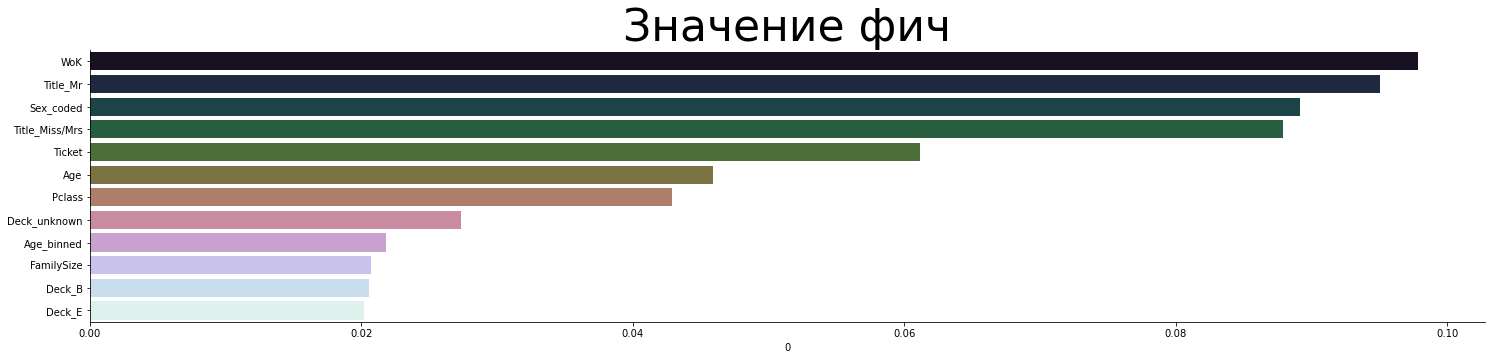

In [40]:
importances = pd.DataFrame(rfc.feature_importances_, index = X_train.columns)
importances.sort_values(by = 0, inplace=True, ascending = False)
importances = importances.iloc[:12]

plt.figure(figsize=(25, 5), facecolor='white') 
sns.barplot(x=0, y=importances.index, data=importances, palette='cubehelix').set_title("Значение фич", fontsize = 44);
sns.despine()

# Визуализация дерева решений

In [77]:
dtc = DecisionTreeClassifier(max_depth=10)
dtc.fit(X_train, y_train)
dtc.score(X_test, y_test)

0.7755960729312763

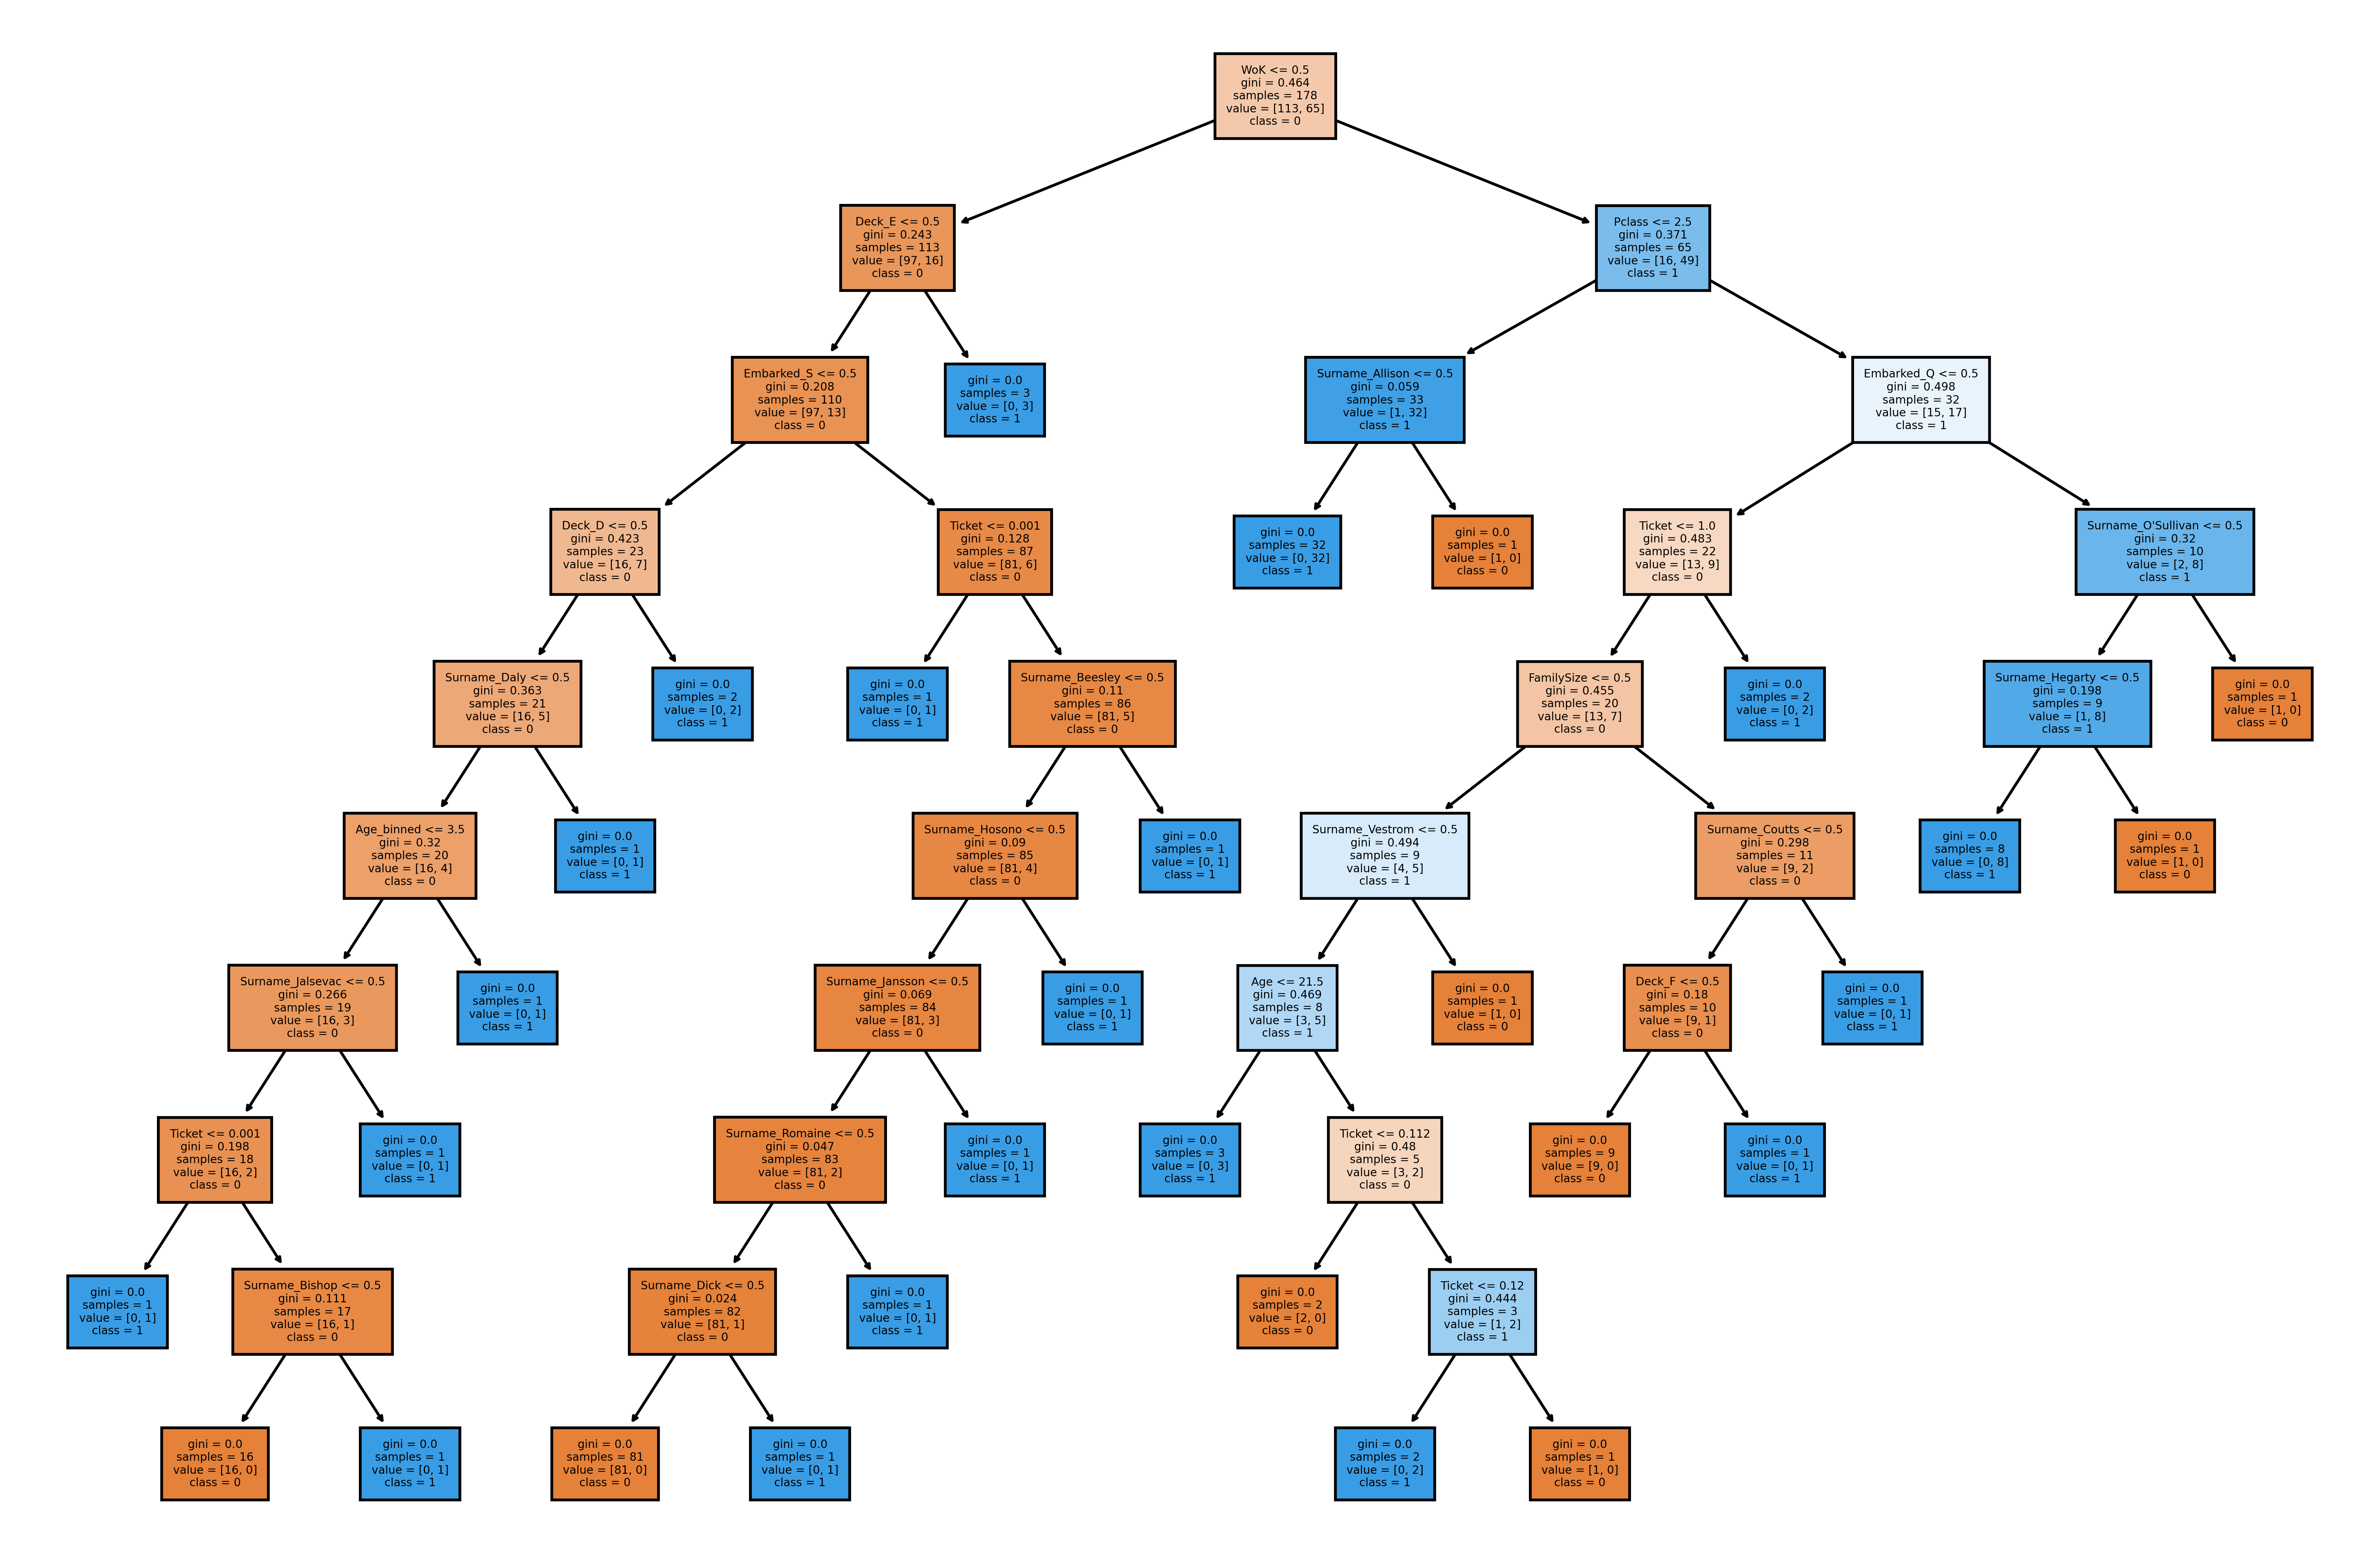

In [79]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (15,10), dpi=600)
tree.plot_tree(dtc, max_depth=10,
               feature_names = X_train.columns, 
               class_names=['0','1'], fontsize=4,
               filled = True);

#### Работаем с целым набором (Для Kaggle)

In [41]:
#Submission_Saver for kagle
def submission_saver(test, predictions):
    output = pd.DataFrame({'PassengerId': test_data.index, 'Survived': predictions})
    output.to_csv('submission.csv', index=False)
    print("Your submission was successfully saved!")

In [42]:
rfc.fit(X, y)
predictions = rfc.predict(test)

In [43]:
submission_saver(test, predictions.astype(int))

Your submission was successfully saved!


#### Выводы

1. Пассажиры, у которых кабина неизвестна погибали с большей вероятностью, нежели остальные. За исключением кабины Т (капитанская)
2. Большие семьи (5 и более членов) и одинокие пассажиры гибли с большей вероятностью, нежели семьи с 2-4 членами.у
3. Мужчины гибли чаще
4. В возрастных группах 13-26 и 66 и старше летальные исходы наблюдались чаще, чем в остальных возрастных подгруппах.
5. Наиболее значимые переменные (5 первых): Женщина/ребенок, Титул Мистер, Пол, Титул Мисс/Миссис, Номер билета.
